# Test Data Analysis
Just messin around

In [1]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [12]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1
{'email': 'Alexxander1611@gmail.com', 'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1'}


In [14]:
# Fetch IMU data

import pandas as pd

imu_coll = db.collection('UserIMU').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data.items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Kappa,mag,1.760566e+09,0,-2.599622,-1.605562,0.696910,1.760566e+09
1,Kappa,mag,1.760566e+09,0,-2.514076,-1.454732,0.724595,1.760566e+09
2,Kappa,mag,1.760566e+09,0,-2.590394,-1.465230,0.723033,1.760566e+09
3,Kappa,mag,1.760566e+09,0,-2.494642,-1.523336,0.770005,1.760566e+09
4,Kappa,mag,1.760566e+09,0,-2.456019,-1.525777,0.760435,1.760566e+09
...,...,...,...,...,...,...,...,...
358,Kappa,gyro,1.760566e+09,0,-0.239775,2.376371,-0.048948,1.760566e+09
359,Kappa,gyro,1.760566e+09,0,-0.140654,2.083520,0.044567,1.760566e+09
360,Kappa,gyro,1.760566e+09,0,-0.319345,1.897856,0.123864,1.760566e+09
361,Kappa,gyro,1.760566e+09,0,-0.195478,1.975102,0.032512,1.760566e+09


In [15]:
# Visualize IMU data of a given type

devname = "Kappa"

gyro = df[df['Type'] == 'gyro']
dev = gyro[gyro['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev.head()


,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
242,Kappa,gyro,1.760566e+09,0,0.574818,-1.113152,0.244297,1.760566e+09,0.000000
243,Kappa,gyro,1.760566e+09,0,0.821596,-0.997488,0.508438,1.760566e+09,0.032590
244,Kappa,gyro,1.760566e+09,0,1.155873,-1.032625,0.504610,1.760566e+09,0.065492
245,Kappa,gyro,1.760566e+09,0,0.862475,-1.218835,0.470567,1.760566e+09,0.096476
246,Kappa,gyro,1.760566e+09,0,0.753646,-1.559949,0.345332,1.760566e+09,0.129013


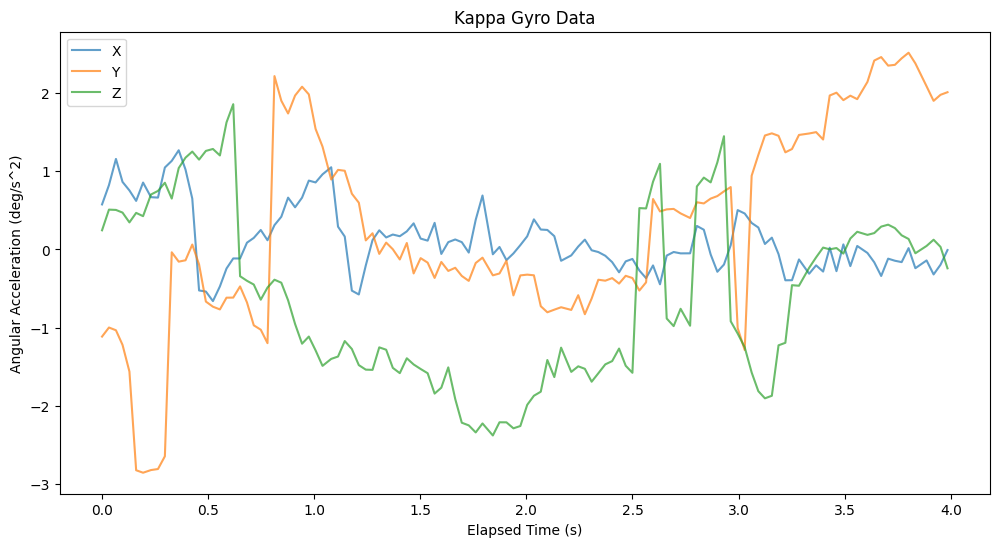

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' Gyro Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Angular Acceleration (deg/s^2)')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie